In [20]:
import numpy as np 
import matplotlib.pyplot as plt 
import readline     



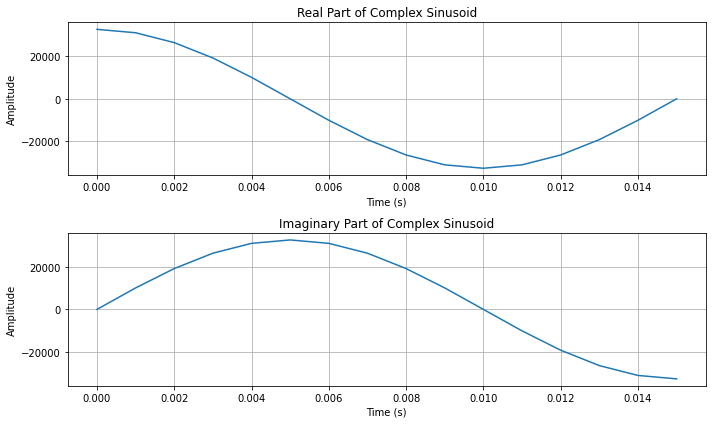

In [21]:
#------------- Complex Sine Wave int16 Data Generation, HEX conversion to .txt file to provide data in Testbench ---------#

def generate_complex_sinusoid(fs, time_samples, f, power, A_fullscale=1.0):
    t = np.arange(time_samples) / fs                        # Time vector
    A_fullscale = 32767;                                    # Full scale amplitude value for int 16 
    amplitude = A_fullscale * 10**(power / 20)              # Amplitude relative to the full scale
    sine_wave = amplitude * np.exp(1j * 2 * np.pi * f * t)  # Generate the complex sinusoid
    
    return t, sine_wave


def iq_int16_conversion(data_fft):
    N = len(data_fft)
    signal_I = np.zeros(N,dtype=np.int16);
    signal_Q = np.zeros(N,dtype=np.int16);
    for i in range(N):
       i_term = np.int16(np.real(data_fft[i])) 
       q_term = np.int16(np.imag(data_fft[i]))  
       signal_I[i] = i_term
       signal_Q[i] = q_term

    return signal_I, signal_Q 


def write_iq_to_hex_file(sine_I,sine_Q, filename):
    N = len(sine_I)
    with open(filename, 'w') as file:
        for i in range(N):
            real_part = sine_I[i]
            imag_part = sine_Q[i]
            real_hex = hex(real_part & 0xffff)[2:].zfill(4)  # 4 characters for 16-bit hexadecimal
            imag_hex = hex(imag_part & 0xffff)[2:].zfill(4)  # 4 characters for 16-bit hexadecimal
            file.write(f"{imag_hex}{real_hex}\n")            # Write the formatted hexadecimal values to the file
    return None 
        
# Parameters
fs = 1000             # Sampling frequency (Hz)
time_samples = 16     # Number of samples
f = 50                # Frequency of the sinusoid (Hz)
power = 0             # Power in dB

t, sine_wave = generate_complex_sinusoid(fs, time_samples, f, power)
sine_I,sine_Q = iq_int16_conversion(sine_wave) # Sine int16 conversion 
write_iq_to_hex_file(sine_I,sine_Q,"fft_input.txt");

# Plot the real and imaginary parts
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t, sine_I)
plt.title('Real Part of Complex Sinusoid')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, sine_Q)
plt.title('Imaginary Part of Complex Sinusoid')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

plt.tight_layout()
plt.show()



In [22]:
#------------------------------- Reference FFT for calculating Difference -----------------------------------------#

data_fft = np.array(np.fft.fft(sine_wave))
fft_int16_ref_I, fft_int16_ref_Q = iq_int16_conversion(data_fft)


In [23]:
#-------------------- HEX To Complex Conversion of HDL FFT  using results obtained from HDL FFT --------------------#

def hex_to_complex(input_path):    
    # Read input file and process each line
    with open(input_path, 'r') as f_in:
        lines = f_in.readlines()
        
    # Process each line and transform 32-bit data into complex numbers
    complex_numbers = []
    for line in lines:
        line = line.strip()
        if len(line) != 8:
            print("Invalid line: {line}. Skipping...")
            continue
        int_value_q = int(line[0:4], 16)  # Convert hexadecimal string to integer
        if int_value_q & (1 << 15):  # Sprawdź, czy najbardziej znaczący bit (bit znaku) jest ustawiony na 1
            int_value_q -= (1 << 16)
             
        int_value_i = int(line[4:8], 16)  # Convert hexadecimal string to integer
        if int_value_i & (1 << 15):  # Check if the most significant bit is set (indicating a negative number in two's complement)
            int_value_i -= (1 << 16)  # Apply two's complement for negative values
        complex_numbers.append(complex(int_value_i, int_value_q))
        
    fft_int16_hdl_I = np.array(np.real(complex_numbers))
    fft_int16_hdl_Q = np.array(np.imag(complex_numbers))
    return fft_int16_hdl_I, fft_int16_hdl_Q


fft_int16_hdl_I, fft_int16_hdl_Q, = hex_to_complex("fft_output.txt")

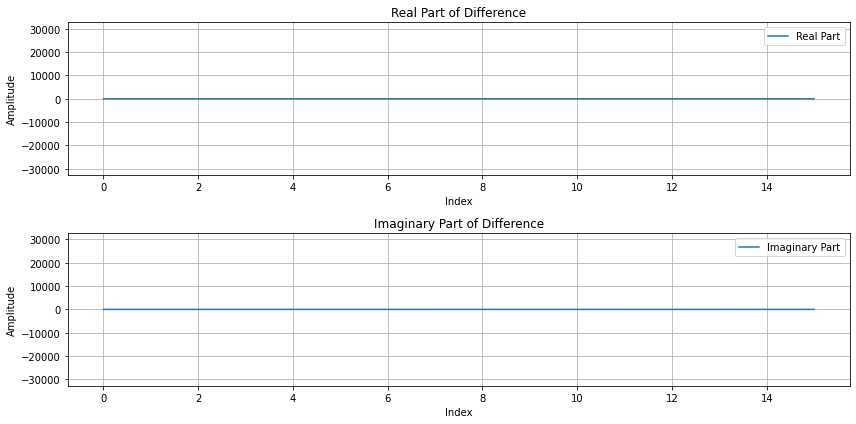

RMS Real Part:  2.5
RMS Imag Part:  2.29128784747792


In [24]:
#------------------------------------- I/Q components comparision -----------------------------------------------------#

difference_I = fft_int16_ref_I - fft_int16_hdl_I
difference_Q = fft_int16_ref_Q - fft_int16_hdl_Q


# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 6))

# Subplot 1: Real Part (I)
plt.subplot(2, 1, 1)
plt.plot(difference_I, label='Real Part')
plt.title('Real Part of Difference')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.ylim([-32768, 32767])  # Set y-axis limits relative to 16-bit int full scale
plt.grid(True)
plt.legend()

# Subplot 2: Imaginary Part (Q)
plt.subplot(2, 1, 2)
plt.plot(difference_Q, label='Imaginary Part')
plt.title('Imaginary Part of Difference')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.ylim([-32768, 32767])  # Set y-axis limits relative to 16-bit int full scale
plt.grid(True)
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Compute RMS values
rms_real = np.sqrt(np.mean(difference_I**2))
rms_imag = np.sqrt(np.mean(difference_Q**2))

print("RMS Real Part: ",rms_real)
print("RMS Imag Part: ",rms_imag)